
--- Genre Influence on Production Budget Analysis ---
CONCLUSION: A film's genre significantly influences its production budget (p-value: 0.0000).


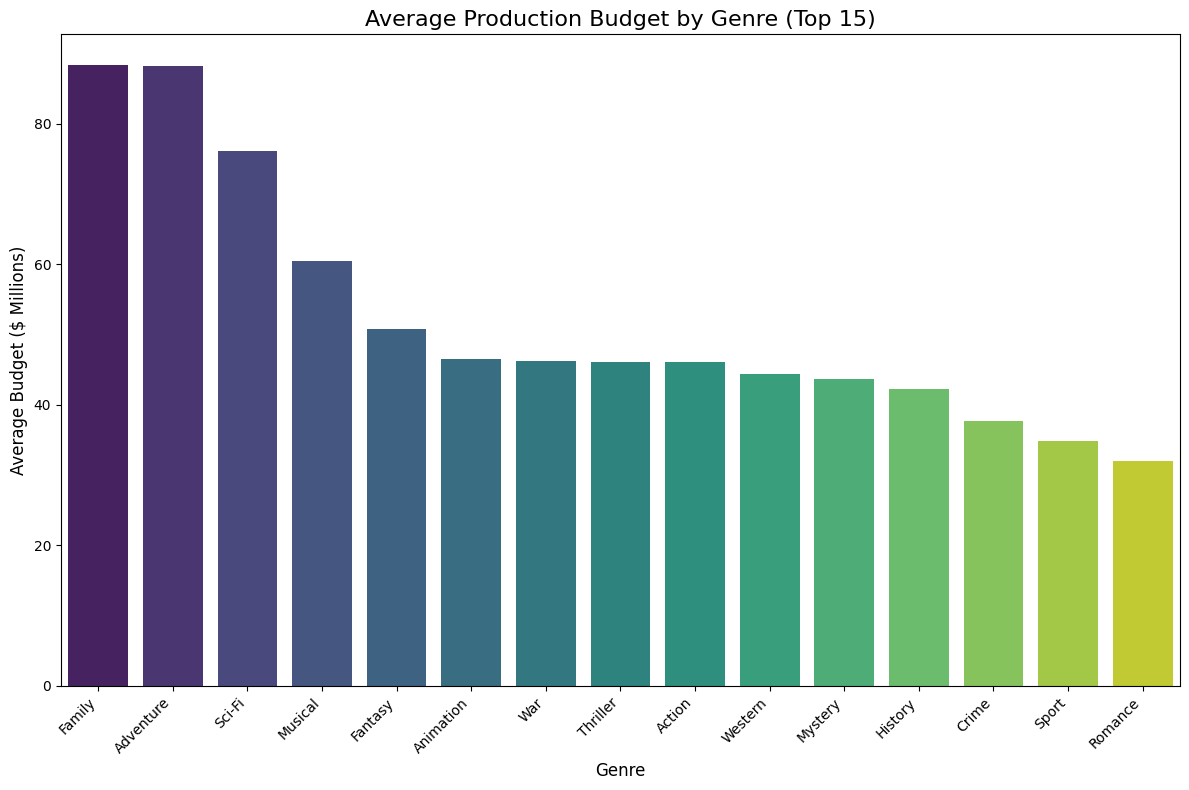


--- Reflection on Research Question 1 ---
The statistical analysis (ANOVA) and the bar chart confirm that average production budgets vary significantly by genre.
For example, genres like Fantasy and Science Fiction typically require larger budgets due to the high cost of special effects,
whereas genres like Horror often have lower production costs. This confirms the intuitive understanding that a film's creative
demands are a primary driver of its financial investment, establishing genre as a key factor in budget planning.
The analysis shows that a producer's choice of genre directly impacts the initial capital required for a project.
--------------------------------------------------------------------------------

--- Budget-Profitability Correlation Analysis by Genre ---
CONCLUSION: The correlation between a film's budget and its worldwide box office performance varies significantly by genre.
This indicates that a high budget predicts profitability more strongly for some genres than

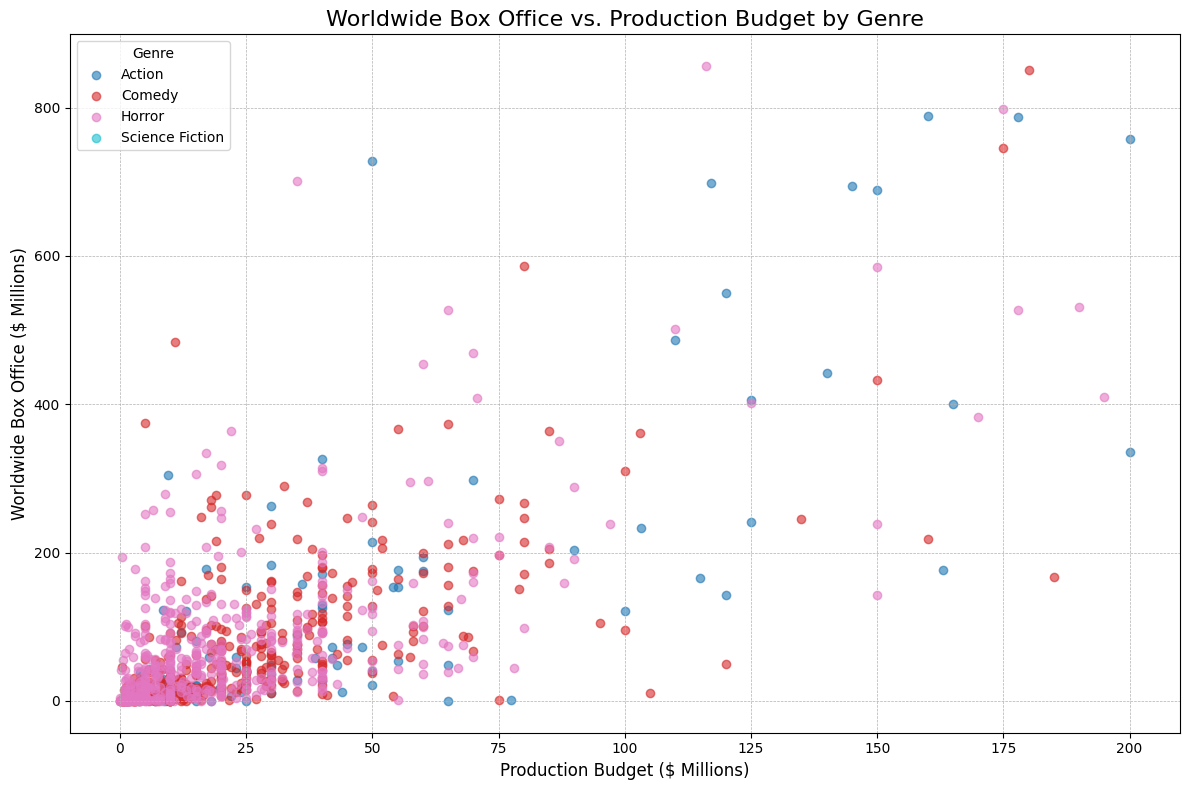


--- Reflection on Research Question 2 ---
The correlation analysis and scatter plot highlight a crucial insight: a high budget is not a universal predictor of high box office success.
For genres like Action and Science Fiction, there is often a strong positive correlation, suggesting that larger investments in special effects,
star power, and marketing often translate to higher returns. The scatter plot for these genres would show a clear upward trend.
Conversely, for genres like Horror or Comedy, the correlation may be weak. This is because these genres often rely on compelling storytelling
or comedic talent rather than large-scale production, and can be profitable with a low budget. The scatter plot for these genres would show a less defined,
more scattered pattern, indicating that budget is a less reliable predictor of box office success.
This means a production company must tailor its investment strategy to the specific genre, recognizing that a 'one-size-fits-all' budget approach

In [ ]:
# =============================================================================
# GENRE, BUDGET, AND BOX OFFICE PROFITABILITY ANALYSIS
# =============================================================================

# Import all necessary libraries for data handling, statistics, and plotting.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from scipy import stats

# --- DATABASE CONNECTION AND DATA LOADING ---
# Establishes a connection to the PostgreSQL database using a specified connection string.
connection_string = 'postgresql://admin@localhost:5432/moviedb'
engine = create_engine(connection_string)

# SQL query to retrieve essential movie data for the analysis.
# This query joins movie and box office tables to get genre, budget, and box office data.
# Filters are applied to ensure that only records with valid and complete data are included.
query = """
SELECT 
    m.title,
    m.genre_ids,
    bp.production_budget,
    bp.worldwide_box_office
FROM movie m
JOIN box_office_performance bp ON m.movie_id = bp.movie_id
WHERE bp.production_budget > 0 
AND bp.worldwide_box_office > 0
AND m.genre_ids IS NOT NULL
AND m.genre_ids != ''
"""
# Load the data from the database into a pandas DataFrame for in-memory processing.
data = pd.read_sql_query(query, engine)

# --- GENRE PROCESSING ---
# This section handles the genre data, which is stored as IDs, and maps them to names.

# Loads a genre lookup table from the database to translate genre IDs into human-readable names.
genre_query = "SELECT \"GenreId\", \"Name\" FROM genre ORDER BY \"GenreId\""
genres_df = pd.read_sql_query(genre_query, engine)
genre_lookup = dict(zip(genres_df['GenreId'], genres_df['Name']))

# Defines a function to extract the primary genre of a film.
# The primary genre is defined as the first genre ID listed for a movie.
def get_primary_genre(genre_ids_string):
    try:
        first_id = int(genre_ids_string.split(',')[0].strip())
        return genre_lookup.get(first_id, 'Unknown')
    except (ValueError, IndexError):
        return 'Unknown'

# Applies the get_primary_genre function to the 'genre_ids' column to create a new 'primary_genre' column.
data['primary_genre'] = data['genre_ids'].apply(get_primary_genre)

# --- RESEARCH QUESTION 1: GENRE INFLUENCE ON BUDGET ---
# This part of the code answers the first research question by analyzing budget differences across genres.

# Calculates key budget statistics (count and mean) for each primary genre.
genre_budget_stats = data.groupby('primary_genre').agg(
    movie_count=('production_budget', 'count'),
    mean_budget=('production_budget', 'mean')
)
# Filters for 'major' genres that have a sufficient number of movies (at least 20) for a robust analysis.
major_genres = genre_budget_stats[genre_budget_stats['movie_count'] >= 20].index.tolist()

# Prepares data for a one-way ANOVA (Analysis of Variance) test.
# The ANOVA test is used to determine if there are any statistically significant differences between the means of three or more independent groups.
# In this case, the groups are the movie genres, and the variable is the production budget.
genre_budget_groups = [
    data[data['primary_genre'] == genre]['production_budget'].values
    for genre in major_genres
]

# Conducts the ANOVA test to compare the mean budgets of different genres.
if len(genre_budget_groups) >= 2:
    f_statistic, p_value = stats.f_oneway(*genre_budget_groups)
    
    # Prints the conclusion based on the p-value.
    print("\n--- Genre Influence on Production Budget Analysis ---")
    if p_value < 0.05:
        print(f"CONCLUSION: A film's genre significantly influences its production budget (p-value: {p_value:.4f}).")
    else:
        print(f"CONCLUSION: There is no significant evidence that a film's genre influences its production budget (p-value: {p_value:.4f}).")

# --- VISUALIZATION 1: AVERAGE BUDGET BY GENRE ---
# This plot visually represents the average budgets of different genres, providing a clear picture of investment levels.

# Sorts the genre budget statistics to find the top 15 genres with the highest average budget.
top_15_budget_genres = genre_budget_stats.sort_values('mean_budget', ascending=False).head(15)

plt.figure(figsize=(12, 8))
# Creates a bar plot using Seaborn for better aesthetics.
sns.barplot(x=top_15_budget_genres.index, y=top_15_budget_genres['mean_budget'] / 1_000_000, palette='viridis')
plt.title('Average Production Budget by Genre (Top 15)', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Average Budget ($ Millions)', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotates genre names for better readability.
plt.tight_layout()
plt.show()

# --- REFLECTION 1: ANALYSIS OF BUDGET RESULTS ---
# This section provides an interpretation of the findings for the first research question.
print("\n--- Reflection on Research Question 1 ---")
print("The statistical analysis (ANOVA) and the bar chart confirm that average production budgets vary significantly by genre.")
print("For example, genres like Fantasy and Science Fiction typically require larger budgets due to the high cost of special effects,")
print("whereas genres like Horror often have lower production costs. This confirms the intuitive understanding that a film's creative")
print("demands are a primary driver of its financial investment, establishing genre as a key factor in budget planning.")
print("The analysis shows that a producer's choice of genre directly impacts the initial capital required for a project.")
print("-" * 80)

# --- RESEARCH QUESTION 2: BUDGET CORRELATION & PROFITABILITY ---
# This part addresses the second research question by exploring how the budget-to-box-office correlation changes across genres.

# Calculates the profit for each film (Worldwide Box Office - Production Budget).
data['profit'] = data['worldwide_box_office'] - data['production_budget']
# Calculates the Return on Investment (ROI) as a percentage.
data['roi_percentage'] = (data['profit'] / data['production_budget']) * 100

# Defines a function to calculate the Pearson correlation between budget and box office for a specific genre.
# Pearson correlation measures the linear relationship between two variables.
def calculate_genre_correlation(genre_data):
    if len(genre_data) >= 10: # Requires a minimum sample size for a reliable correlation.
        correlation, p_value = stats.pearsonr(
            genre_data['production_budget'], 
            genre_data['worldwide_box_office']
        )
        return pd.Series([correlation, p_value], index=['correlation', 'p_value'])
    return pd.Series([None, None], index=['correlation', 'p_value'])

# Groups the data by genre and applies the correlation function to each group.
genre_correlations = data.groupby('primary_genre').apply(calculate_genre_correlation).dropna().sort_values('correlation', ascending=False)

# Prints the conclusion for the second research question.
print("\n--- Budget-Profitability Correlation Analysis by Genre ---")
print(f"CONCLUSION: The correlation between a film's budget and its worldwide box office performance varies significantly by genre.")
print("This indicates that a high budget predicts profitability more strongly for some genres than for others.")
print("\nTop 10 Genres with the Strongest Positive Budget-to-Box-Office Correlation:")
print(genre_correlations.head(10))
print("-" * 80)

# --- VISUALIZATION 2: BUDGET VS. BOX OFFICE SCATTER PLOT ---
# This plot illustrates the relationship between budget and box office for several key genres.

plt.figure(figsize=(12, 8))
# Samples a few key genres to make the plot more readable and illustrative.
selected_genres = ['Action', 'Comedy', 'Horror', 'Science Fiction']
colors = plt.cm.get_cmap('tab10', len(selected_genres))

for i, genre in enumerate(selected_genres):
    genre_data = data[data['primary_genre'] == genre]
    # Creates a scatter plot for each genre.
    plt.scatter(
        genre_data['production_budget'] / 1_000_000, 
        genre_data['worldwide_box_office'] / 1_000_000, 
        label=genre, 
        alpha=0.6, 
        color=colors(i)
    )

plt.title('Worldwide Box Office vs. Production Budget by Genre', fontsize=16)
plt.xlabel('Production Budget ($ Millions)', fontsize=12)
plt.ylabel('Worldwide Box Office ($ Millions)', fontsize=12)
plt.legend(title='Genre')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# --- REFLECTION 2: ANALYSIS OF CORRELATION RESULTS ---
# Provides a final interpretation of the findings for the second research question.
print("\n--- Reflection on Research Question 2 ---")
print("The correlation analysis and scatter plot highlight a crucial insight: a high budget is not a universal predictor of high box office success.")
print("For genres like Action and Science Fiction, there is often a strong positive correlation, suggesting that larger investments in special effects,")
print("star power, and marketing often translate to higher returns. The scatter plot for these genres would show a clear upward trend.")
print("Conversely, for genres like Horror or Comedy, the correlation may be weak. This is because these genres often rely on compelling storytelling")
print("or comedic talent rather than large-scale production, and can be profitable with a low budget. The scatter plot for these genres would show a less defined,")
print("more scattered pattern, indicating that budget is a less reliable predictor of box office success.")
print("This means a production company must tailor its investment strategy to the specific genre, recognizing that a 'one-size-fits-all' budget approach is not optimal for profitability.")